# calcanoms 

This is the third step in reproducing the cluster analysis from Sara and David following Amini et al 2019
https://doi.org/10.1007/s00382-018-4409-7

This program:
1. Calculates the seasonal cycle for the DJF Z500 and U250 data
* Input File: `/project/predictability/kpegion/wxregimes/era-interim/erai.z500_u250_pna_5dyrm_DJF.1980-2015.nc`
* Seasonal cycle is calculated using David's parabola method
* Fit a parabola at each grid point over all days in the season for each year
* Average the parabola at each grid point over all years, this is the climatological seasonal cycle
2. Calculates the anomalies
* By removing the climatological seasonal cycle from the full fields
3. Writes anomalies to a single netcdf file containing both variables
* Output File: `/project/predictability/kpegion/wxregimes/era-interim/erai.z500_u250_pna_5dyrm_DJF.1980-2015.anoms.nc`

In [1]:
def climo_parabola(da):
  
    nt,ny,nx=da.shape
    print(da.shape)
    ndays=88
    nyr=int(nt/ndays)
    
    
    poly=np.zeros((nyr,ndays,ny,nx))
    x=np.arange(ndays)
    y=da.reshape(nyr,ndays,nx*ny)

    for iyr in range(nyr):
        pfitcoeffs=np.polyfit(x,y[iyr,:,:],3)
    
        k=0
        for j in range(ny):
            for i in range(nx):
                poly[iyr,:,j,i]=np.polyval(pfitcoeffs[:,k],x)
                k+=1
    climo=poly.mean(axis=0)
    
    return climo

In [2]:
def make_anoms(da,climo):

    nt,ny,nx=da.shape
    ndays=88
    nyr=int(nt/ndays)
    y=da.reshape(nyr,ndays,ny,nx)

    anoms=np.zeros((nyr,ndays,ny,nx))

    for iyr in range(nyr):
        anoms[iyr,:,:,:]=y[iyr,:,:,:]-climo 
        
    anoms=anoms.reshape(nt,ny,nx)
    
    return anoms

In [3]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

### Define input and output files

In [4]:
# Input
path='/project/predictability/kpegion/wxregimes/era-interim/'
fname='erai.z500_u250_pna_5dyrm_DJF.1980-2015.nc'

# Output
out_path='/project/predictability/kpegion/wxregimes/era-interim/'
ofname='erai.z500_u250_pna_5dyrm_DJF.1980-2015.anoms.nc'
outfile=out_path+ofname

### Set the list of years

In [5]:
yrs_list=np.arange(1981,2016)

### Read the data

In [6]:
ds=xr.open_dataset(path+fname,decode_times=True)
ds

<xarray.Dataset>
Dimensions:  (lat: 22, lon: 53, time: 3080)
Coordinates:
  * lat      (lat) float64 79.53 76.74 73.95 71.16 ... 29.3 26.51 23.72 20.93
  * lon      (lon) float64 151.9 154.7 157.5 160.3 ... 289.7 292.5 295.3 298.1
  * time     (time) datetime64[ns] 1980-12-03 1980-12-04 ... 2015-02-28
Data variables:
    z500     (time, lat, lon) float64 ...
    u250     (time, lat, lon) float64 ...

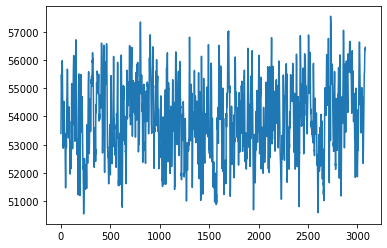

In [7]:
plt.plot(ds['z500'][:,12,25])

In [1]:
plt.plot(ds['u250'][0:88,12,25])

NameError: name 'plt' is not defined

In [9]:
climo_z500=climo_parabola(ds['z500'].values)
climo_u250=climo_parabola(ds['u250'].values)

(3080, 22, 53)
(3080, 22, 53)


In [10]:
anoms_z500=make_anoms(ds['z500'].values,climo_z500)
anoms_u250=make_anoms(ds['u250'].values,climo_u250)
anoms_u250.shape

(3080, 22, 53)

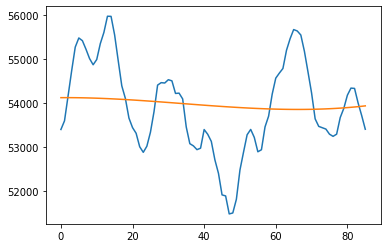

In [11]:
plt.plot(ds['z500'][0:88,12,25])
plt.plot(climo_z500[0:88,12,25])

In [12]:
ds_z500_anoms=xr.DataArray(anoms_z500,
                coords={'time':np.arange(len(ds['time'])),
                        'lat':ds['lat'],
                        'lon': ds['lon']},
                        dims=['time','lat','lon'])        
ds_z500_anoms=ds_z500_anoms.to_dataset(name='z500')

ds_u250_anoms=xr.DataArray(anoms_u250,
                coords={'time':np.arange(len(ds['time'])),
                        'lat':ds['lat'],
                        'lon': ds['lon']},
                        dims=['time','lat','lon'])        
ds_u250_anoms=ds_u250_anoms.to_dataset(name='u250')

ds_anoms=xr.merge([ds_z500_anoms,ds_u250_anoms])

In [13]:
ds_anoms

<xarray.Dataset>
Dimensions:  (lat: 22, lon: 53, time: 3080)
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 ... 3073 3074 3075 3076 3077 3078 3079
  * lat      (lat) float64 79.53 76.74 73.95 71.16 ... 29.3 26.51 23.72 20.93
  * lon      (lon) float64 151.9 154.7 157.5 160.3 ... 289.7 292.5 295.3 298.1
Data variables:
    z500     (time, lat, lon) float64 -1.429e+03 -1.504e+03 ... 451.6 441.6
    u250     (time, lat, lon) float64 2.737 2.028 1.413 ... -15.37 -16.44 -17.88

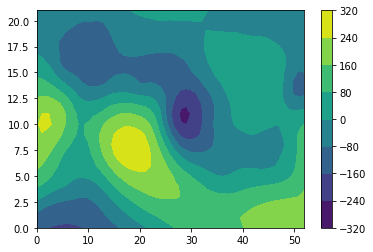

In [14]:
plt.contourf(ds_anoms['z500'][0,:,:])
plt.colorbar()

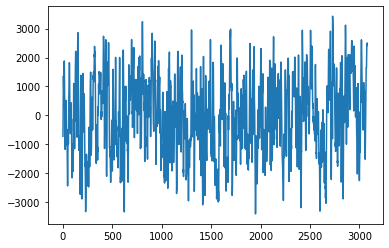

In [15]:
plt.plot(ds_anoms['z500'][:,12,25])

### Write to netcdf

In [17]:
ds_anoms.to_netcdf(outfile)